In [3]:
import mujoco
import casadi
import numpy as np
import mediapy as media

In [9]:
# because of linearity purposes the derivative fcn needs to be defined first

class hopper_transition_jac(casadi.Callback):
    def __init__(self, name, opts={}):
        opts['enable_fd'] = True
        casadi.Callback.__init__(self)
        self.construct(name, opts)

    # for some reason casadi gives the output of the original fcn call to the derivative call
    def get_n_in(self): return 3
    # return two jacs, one wrt s and the other wrt u
    def get_n_out(self): return 2

    # define shape of input arguments
    def get_sparsity_in(self, n_in):
        # this will depend on the exact mujoco model we are using
        if n_in == 0: return casadi.Sparsity.dense(12)
        if n_in == 1: return casadi.Sparsity.dense(3)
        if n_in == 2: return casadi.Sparsity.dense(12)

    def get_sparsity_out(self, n_out):
        # dimensions of jac matrix we are returning
        # see docs on mjd_transitionFD for more info on jac matrix dim
        if n_out == 0: return casadi.Sparsity.dense(12, 12)
        if n_out == 1: return casadi.Sparsity.dense(12, 3)

    
    def init(self):
        # want to init the mujoco model here
        xml = open("hopper.xml", 'r').read()
        self.model = mujoco.MjModel.from_xml_string(xml)
        self.data = mujoco.MjData(self.model)

    def eval(self, arg):
        # extract args
        # in order to copy them into mujoco data, they need to be cast to a numpy array
        # note the flattening to change shape from (n, 1) to (n,)
        s = np.array(arg[0])
        u = np.array(arg[1]).flatten()
        fcn_eval = arg[2] # i dont think we need this one, or at least mujuco doesn't need

        # mujoco handles qpos and qvel separately, so we must separate these states
        # you will probably need to change these numbers
        qpos = np.array(s[:6]).flatten()
        qvel = np.array(s[6:]).flatten()
        
        # we set the data to desired state and control
        self.data.qpos = qpos
        self.data.qvel = qvel
        self.data.ctrl = u

        output1 = np.ndarray((12,12), dtype=np.float64)
        output2 = np.ndarray((12,3), dtype=np.float64)

        # we discard the other outputs, dont care about sensor data
        mujoco.mjd_transitionFD(self.model, self.data, 0.001, 1, output1, output2, None, None)
        
        return [output1, output2]

In [10]:
# want to build state transition function with signature state x control -> updated state

class hopper_transition(casadi.Callback):
    def __init__(self, name, opts={}):
        casadi.Callback.__init__(self)
        self.construct(name, opts)

    def get_n_in(self): return 2
    def get_n_out(self): return 1

    # define shape of input arguments
    def get_sparsity_in(self, n_in):
        # this will depend on the exact mujoco model we are using
        # for hopper the state vector is of length 12 and control is length 3
        # these numbers will have to be changed for different models
        # note that the state consists of the qpos and the qvel
        if n_in == 0: return casadi.Sparsity.dense(12)
        if n_in == 1: return casadi.Sparsity.dense(3)
        print(n_in)

    def get_sparsity_out(self, n_out):
        return casadi.Sparsity.dense(12)
    
    def init(self):
        # want to init the mujoco model here
        xml = open("hopper.xml", 'r').read()
        self.model = mujoco.MjModel.from_xml_string(xml)
        self.data = mujoco.MjData(self.model)

        # set the renderer flags here for visualization purposes.
        self.visualization = False
        self.scene_option = mujoco.MjvOption()
        self.scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

        # register derivative of function
        self.df = hopper_transition_jac('df')

    def eval(self, arg):
        # extract args
        # in order to copy them into mujoco data, they need to be cast to a numpy array
        # note the flattening to change shape from (n, 1) to (n,)
        s = np.array(arg[0])
        u = np.array(arg[1]).flatten()

        # mujoco handles qpos and qvel separately, so we must separate these states
        # you will probably need to change these numbers
        qpos = np.array(s[:6]).flatten()
        qvel = np.array(s[6:]).flatten()

        # some models will have a qact for activation. if your model has this lmk because
        # im not sure what to do about that one tbh
        
        # we set the data to desired state and control
        self.data.qpos = qpos
        self.data.qvel = qvel
        self.data.ctrl = u

        mujoco.mj_step(self.model, self.data)
        
        # visualization for debug purposes
        if self.visualization:
            with mujoco.Renderer(self.model) as renderer:
                renderer.update_scene(self.data, scene_option=self.scene_option)
                media.show_image(renderer.render())
        
        output = np.append(self.data.qpos, self.data.qvel)
        return [output]
    
    def has_jacobian(self, *args) -> bool:
        return True
    
    # return a casadi function handle to the jacobian
    def get_jacobian(self, name, inames, onames, opts={}):
        print(name, inames, onames)
        # input shapes
        x = casadi.MX.sym(inames[0], 12)
        u = casadi.MX.sym(inames[1], 3)
        out = casadi.MX.sym(inames[2], 12)
        jacs = self.df(x,u, out)
        return casadi.Function(name, [x, u, out], jacs)

In [22]:
# define time horizon in secs
T = 0.50
TIME_STEP = 0.01 # default mujoco stepping seems like
N = int(T/TIME_STEP)

state_dim = 12
ctrl_dim = 3

opti = casadi.Opti()

# declare variables
X = opti.variable(state_dim, N+1)
U = opti.variable(ctrl_dim, N)
P = opti.parameter(state_dim) # inital state

f = hopper_transition('f')

opti.minimize((0.5+X[0, -1])**2) # try to hover at distance 0.5
opti.subject_to(X[:, 0] == P) # initial state is fixed to parameter

for k in range(N):
    # subsequent states are governed by state transition
    opti.subject_to(X[:, k+1] == f(X[:, k], U[:, k]))

for k in range(N): # control constraints
    opti.subject_to(opti.bounded([-1,-1,-1], U[:, k], [1,1,1]))


In [23]:
opts = {}
# neccesary to avoid hessian computations that we cannot produce with mujoco setup
# opts['ipopt.hessian_approximation'] = 'limited-memory'
# opts['ipopt.derivative_test'] = 'second-order'
# opts['expand'] = True

# the initial state the hopper is in
initial_state = np.array([0,   1.25, 0,  0,   0,   0,   0,   0,   0,   0,   0,   0,  ])

opti.solver('ipopt', opts)
opti.set_value(P, initial_state)
sol=opti.solve()
print(sol)

jac_f ['i0', 'i1', 'out_o0'] ['jac_o0_i0', 'jac_o0_i1']
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4812
Number of nonzeros in inequality constraint Jacobian.:       75
Number of nonzeros in Lagrangian Hessian.............:     3001

Total number of variables............................:      387
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:       75
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       75
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5000000e-01 5

Function f (0x17a56cac280)
Input 0 (i0): [-0.00610505, 1.24805, -0.0503501, -0.0377397, -0.0372895, -0.0281599, -0.49694, -0.18862, -4.09563, -3.05204, -3.06003, -2.24013]
Input 1 (i1): [-0.695586, -0.81169, -0.48414]
Function nlp_g (0x17a7c7e16a0)
Input 0 (x): [1.72349e-25, 1.25, 1.20587e-28, 1.32385e-28, -2.66604e-24, -1.47109e-23, -2.11307e-25, -2.19401e-26, -1.39654e-22, -6.43864e-23, 4.38602e-22, -1.49992e-22, -4.38299e-05, 1.24999, -0.000361917, -0.000273285, -0.000264664, -0.000209727, -0.0438189, -0.0112262, -0.361823, -0.273208, -0.2646, -0.209672, -0.00017495, 1.24995, -0.0014445, -0.00109033, -0.00105717, -0.000835127, -0.0872913, -0.0227275, -0.720675, -0.543761, -0.527845, -0.415679, -0.000392652, 1.2499, -0.00324166, -0.00244565, -0.00237473, -0.00186874, -0.1304, -0.0346775, -1.0764, -0.811488, -0.789655, -0.617895, -0.000696185, 1.24982, -0.00574697, -0.00433342, -0.00421439, -0.00330286, -0.173124, -0.0472454, -1.42883, -1.0762, -1.04994, -0.816181, -0.00108476, 1.2497

 409  2.2478555e-01 2.68e-03 2.02e-02  -3.8 1.89e-02    -  1.00e+00 7.81e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  2.2478557e-01 2.68e-03 2.01e-02  -3.8 1.88e-02    -  1.00e+00 1.95e-03h 10
 411  2.2478558e-01 2.68e-03 2.01e-02  -3.8 1.87e-02    -  1.00e+00 4.88e-04h 12
 412  2.2479458e-01 7.22e-04 7.72e-02  -3.8 1.87e-02    -  1.00e+00 1.00e+00h  1
 413  2.2476800e-01 1.36e-03 1.18e-01  -3.8 8.52e-02    -  1.00e+00 1.00e+00h  1
 414  2.2478779e-01 4.74e-03 1.18e-01  -3.8 8.34e-02    -  1.00e+00 1.00e+00h  1
 415  2.2476791e-01 1.29e-03 1.18e-01  -3.8 8.34e-02    -  1.00e+00 1.00e+00h  1
 416  2.2478780e-01 4.74e-03 1.18e-01  -3.8 8.34e-02    -  1.00e+00 1.00e+00h  1
 417  2.2477785e-01 1.88e-03 9.63e-02  -3.8 8.34e-02    -  1.00e+00 5.00e-01h  2
 418  2.2480364e-01 8.84e-03 1.53e-01  -3.8 1.24e-01    -  1.00e+00 1.00e+00h  1
 419  2.2478472e-01 3.46e-03 7.63e-02  -3.8 1.72e-01    -  1.00e+00 5.00e-01h  2


In [20]:
opti.debug.value(U)


array([[-0.9999984 , -0.99999813, -0.99999778, -0.99999734, -0.99999678,
        -0.99999602, -0.99999495, -0.99999323, -0.99998973, -0.99997702],
       [-0.99999886, -0.99999868, -0.99999846, -0.99999818, -0.9999978 ,
        -0.9999973 , -0.99999655, -0.99999532, -0.9999927 , -0.99998236],
       [-0.99999748, -0.99999696, -0.99999629, -0.99999544, -0.99999436,
        -0.99999298, -0.99999116, -0.99998851, -0.99998362, -0.99996814]])

In [21]:
opti.debug.value(X)[:,-1]

array([-0.00517155,  1.24899827, -0.04253114, -0.03304699, -0.02865597,
       -0.03355982, -0.51625998, -0.11966045, -4.24718052, -3.29493102,
       -2.8586762 , -3.349743  ])

[0.   1.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ] 12


""

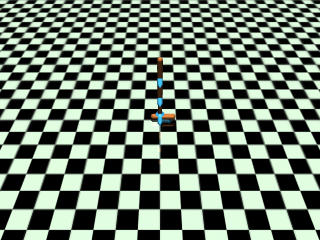

0.004


In [607]:
# some test code

with open("hopper.xml", 'r') as xml_file:
    xml = xml_file.read()

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

mujoco.mj_resetData(model, data)

x = np.append(data.qpos, data.qvel)
print(x, len(x))
u = np.array([0,0,0])

out = f(x, u)

""

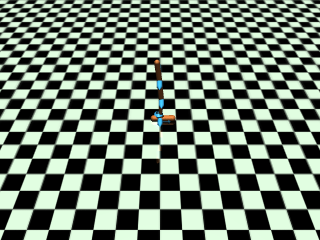

0.9300000000000007
[-0.029694, 1.20344, -0.105404, -0.0277998, -0.13048, 0.057089, -0.0980442, -0.0207538, -0.355341, -0.0983276, -0.432754, 0.174011]


In [599]:
out = f(out, u)
print(out)